In [2]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg19 = VGG19(weights = "imagenet" , 
              include_top = False , 
              input_shape = (224 , 224 , 3)) 
for layer in vgg19.layers:
  layer.trainable = False 
for (i , layer) in enumerate(vgg19.layers):
  print(str(i) + " " + layer.__class__.__name__ , layer.trainable) 

80134624/80134624 [==============================] - 4s 0us/step
0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 Conv2D False
11 MaxPooling2D False
12 Conv2D False
13 Conv2D False
14 Conv2D False
15 Conv2D False
16 MaxPooling2D False
17 Conv2D False
18 Conv2D False
19 Conv2D False
20 Conv2D False
21 MaxPooling2D False


In [3]:
def addtopmodelvgg19(bottom_model , num_classes):
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model) 
  top_model = Dense(1024 , activation = "relu")(top_model) 
  top_model = Dense(1024 , activation = "relu")(top_model) 
  top_model = Dense(512 , activation = "relu")(top_model)  
  top_model = Dense(num_classes , activation = "softmax")(top_model) 
  return top_model

In [4]:
from keras.models import Sequential , Model 
from keras.layers import Dense, Dropout  ,Flatten , MaxPooling2D , BatchNormalization , LeakyReLU 
from keras.layers import Conv2D , Conv2DTranspose , GlobalAveragePooling2D
num_classes = 4
FCHead = addtopmodelvgg19(vgg19 , num_classes) 
model = Model(inputs = vgg19.inputs , outputs = FCHead) 
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

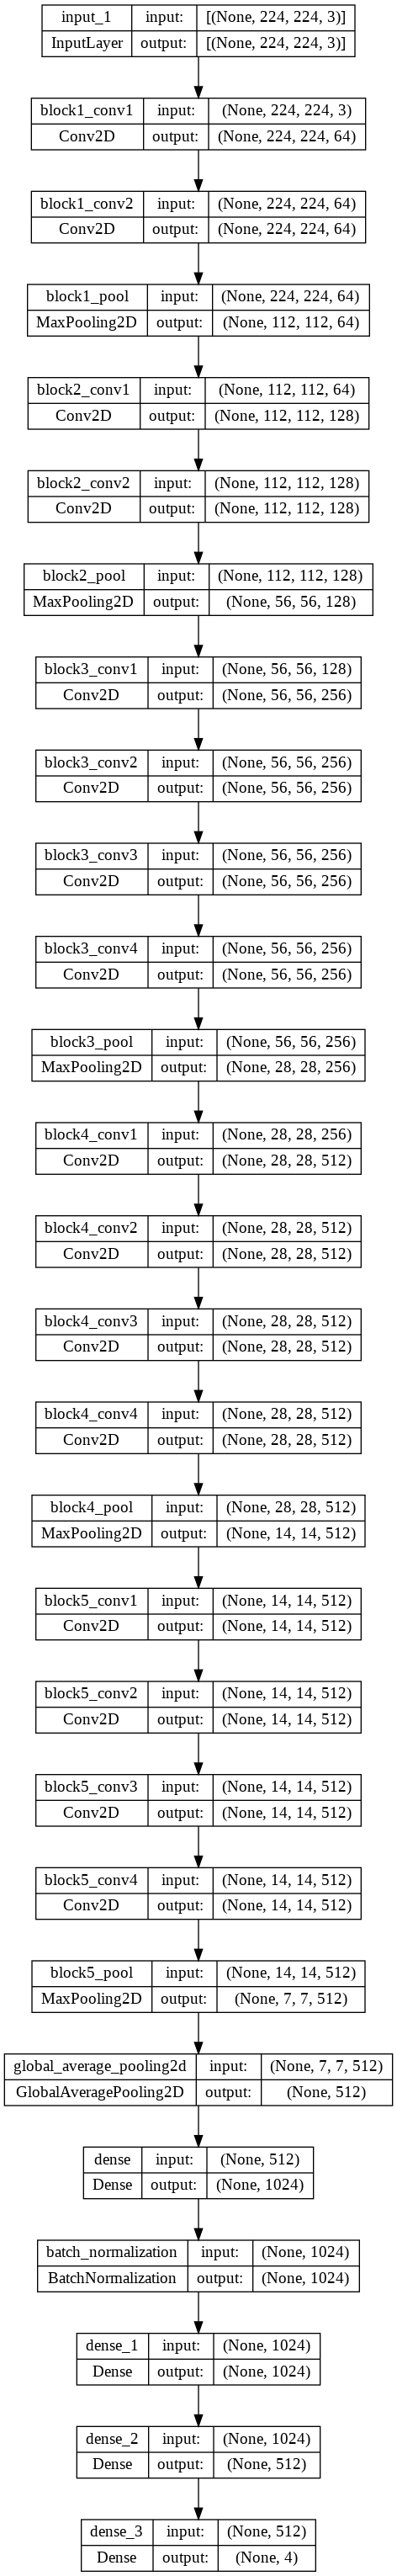

In [6]:
from tensorflow.keras.utils import plot_model
plot_model(
    model,
    to_file='vgg19_model.png',
    show_shapes=True)

In [7]:
from keras.preprocessing.image import ImageDataGenerator 
train_dir = "Brain_Dataset/Training/"
test_dir = "Brain_Dataset/Testing/"

train_datagen = ImageDataGenerator(rescale = 1./255 , 
                                   shear_range = 0.2 , 
                                   zoom_range = 0.2 , 
                                   width_shift_range= 0.2 , 
                                   height_shift_range = 0.3 , 
                                   horizontal_flip = True , 
                                   validation_split = 0.2) 
test_datagen = ImageDataGenerator(rescale = 1./255)
train_dataset = train_datagen.flow_from_directory(train_dir , 
                                                  target_size = (224 , 224) , 
                                                  class_mode = "categorical" , 
                                                  batch_size = 32)
validation_dataset = train_datagen.flow_from_directory(train_dir , 
                                                  target_size = (224 , 224) , 
                                                  class_mode = "categorical" , 
                                                  batch_size = 32)
test_dataset = test_datagen.flow_from_directory(test_dir , 
                                                  target_size = (224 , 224) , 
                                                  class_mode = "categorical" , 
                                                  batch_size = 32)

Found 2870 images belonging to 4 classes.
Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


In [7]:
from keras.callbacks import ModelCheckpoint , EarlyStopping , ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop

modelcheck = ModelCheckpoint("MyDrive/vgg19.h5" , 
                             monitor = "val_loss" , 
                             mode = "min" , 
                             verbose =1 , 
                             save_best_only = True)
early_stop = EarlyStopping(monitor = "val_loss" , 
                           min_delta = 0 , 
                           patience = 4 ,
                           verbose = 1 ,
                           restore_best_weights = True) 
reducelr = ReduceLROnPlateau(monitor = "val_loss" , 
                             min_delta = 0.0001 , 
                             patience = 4 , 
                             verbose = 1 , 
                             factor =0.2)
callbacks = [modelcheck , early_stop , reducelr] 

model.compile(loss = "categorical_crossentropy" , 
              optimizer = RMSprop(learning_rate = 0.001) , 
              metrics = ["accuracy"])
batch_size = 16
epochs = 30
history = model.fit(train_dataset , 
            epochs = epochs , 
            batch_size = batch_size , 
            validation_data = validation_dataset , 
            callbacks = callbacks)

Epoch 1/30
90/90 [==============================] - ETA: 0s - loss: 0.7320 - accuracy: 0.7328
Epoch 1: val_loss improved from inf to 0.54007, saving model to /content/drive/MyDrive/vgg19.h5
90/90 [==============================] - 94s 1s/step - loss: 0.7320 - accuracy: 0.7328 - val_loss: 0.5401 - val_accuracy: 0.7868 - lr: 0.0010
Epoch 2/30
90/90 [==============================] - ETA: 0s - loss: 0.6403 - accuracy: 0.7460
Epoch 2: val_loss did not improve from 0.54007
90/90 [==============================] - 93s 1s/step - loss: 0.6403 - accuracy: 0.7460 - val_loss: 0.6721 - val_accuracy: 0.7296 - lr: 0.0010
Epoch 3/30
90/90 [==============================] - ETA: 0s - loss: 0.6556 - accuracy: 0.7456
Epoch 3: val_loss did not improve from 0.54007
90/90 [==============================] - 92s 1s/step - loss: 0.6556 - accuracy: 0.7456 - val_loss: 0.6722 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 4/30
90/90 [==============================] - ETA: 0s - loss: 0.6395 - accuracy: 0.7355
Epoch 4:

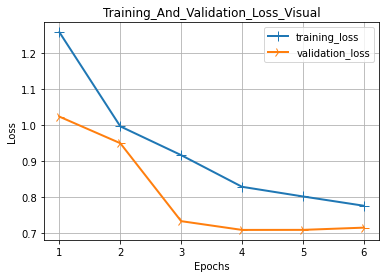

In [8]:
import matplotlib.pyplot as plt
history_dict = history.history 
loss_val = history_dict["loss"] 
val_loss = history_dict["val_loss"]
epochs = range(1, len(loss_val)+1) 

line1 = plt.plot(epochs , loss_val , label = "training_loss") 
line2 = plt.plot(epochs , val_loss , label = "validation_loss")
plt.setp(line1 , linewidth = 2.0 , marker = "+" , markersize = 10.0) 
plt.setp(line2 , linewidth = 2.0 , marker = "4" , markersize = 10.0)
plt.title("Training_And_Validation_Loss_Visual") 
plt.xlabel("Epochs") 
plt.ylabel("Loss") 
plt.legend() 
plt.grid(True) 
plt.show() 

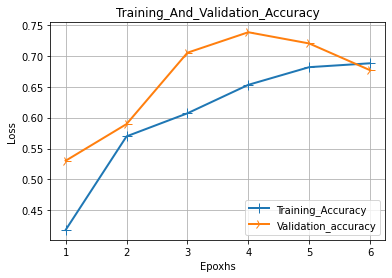

In [9]:
acc_val = history_dict["accuracy"] 
val_acc = history_dict["val_accuracy"] 
epochs = range(1 , len(val_acc)+1) 

line1 = plt.plot(epochs , acc_val , label = "Training_Accuracy") 
line2 = plt.plot(epochs , val_acc , label = "Validation_accuracy") 
plt.setp(line1 , linewidth = 2.0 , marker = "+" , markersize = 10.0) 
plt.setp(line2 , linewidth = 2.0 , marker = "4" , markersize = 10.0)  
plt.title("Training_And_Validation_Accuracy")
plt.xlabel("Epoxhs") 
plt.ylabel("Loss") 
plt.legend()
plt.grid(True) 
plt.show()


In [10]:
_ , test_acc = model.evaluate(test_dataset , steps = None , callbacks = None , max_queue_size=10 , workers = 1 , use_multiprocessing = False) 
print("Test_acc" , test_acc*100) 

25/25 [==============================] - 78s 3s/step - loss: 1.4390 - accuracy: 0.4391
Test_acc 43.908628821372986


In [1]:
from keras.models import load_model
model = load_model("models_weights//vgg19.h5")

In [2]:
import cv2 
import os 
import numpy as np 
from os import listdir 
from os.path import isfile , join 

brain_detection_dict = {"[0]":"glioma_tumor" ,
                       "[1]" : "meningioma_tumor" ,
                       "[2]":"no_tumor" , 
                       "[3]":"pituitary_tumor"}
brain_detection_dict_n = {"glioma_tumor":"glioma_tumor" ,
                       "meningioma_tumor" : "meningioma_tumor" ,
                       "no_tumor":"no_tumor" , 
                       "pituitary_tumor" : "pituitary_tumor"} 
def draw_test(name, pred , im):
    lungs = brain_detection_dict[str(pred)]
    BLACK = [0,0,0]
    expanded_image = cv2.copyMakeBorder(im , 80 , 0,0,100 , cv2.BORDER_CONSTANT , value = BLACK)
    cv2.putText(expanded_image , lungs , (20,60) , cv2.FONT_HERSHEY_SIMPLEX , 1 , (0,255,0) , 2) 
    return cv2.imshow(name , expanded_image)
def get_random_test(path):
    folder = list(filter(lambda x: os.path.isdir(os.path.join(path , x)) ,os.listdir(path)))
    random_directory = np.random.randint(0 , len(folder))
    path_class = folder[random_directory]
    print("predicted_class :" + brain_detection_dict_n[str(path_class)]) 
    file_path = path + path_class 
    file_name = [f for f in listdir(file_path) if isfile(join(file_path , f))]
    random_directory_index = np.random.randint(0 , len(file_name))
    image_name = file_name[random_directory_index]
    return cv2.imread(file_path + "/" + image_name)
for i in range(0 , 10):
    input_im = get_random_test("Brain_Dataset/Testing/")
    original_im = input_im.copy()
    original_im = cv2.resize(original_im , None , fx = 0.7 , fy = 0.7 , interpolation = cv2.INTER_NEAREST) 
    
    input_im = cv2.resize(input_im , (224 ,224 ) , interpolation = cv2.INTER_NEAREST)
    input_im = input_im / 255. 
    input_im = input_im.reshape(1,224 ,224 , 3) 
    res = np.argmax(model.predict(input_im , 1 , verbose=0) , axis = 1) 
    draw_test("prediction" , res , original_im)
    cv2.waitKey(0)
cv2.destroyAllWindows()

predicted_class :no_tumor
predicted_class :meningioma_tumor
predicted_class :pituitary_tumor
predicted_class :pituitary_tumor
predicted_class :glioma_tumor
predicted_class :pituitary_tumor
predicted_class :meningioma_tumor
predicted_class :no_tumor
predicted_class :meningioma_tumor
predicted_class :pituitary_tumor


Prediction no_tumor


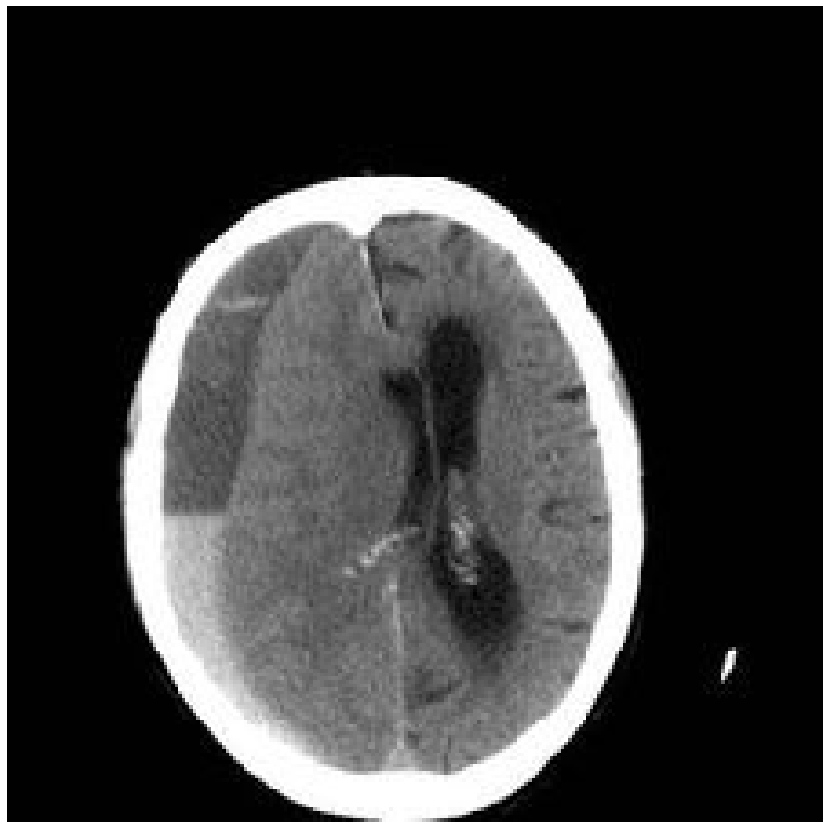

In [6]:
from tensorflow.keras.preprocessing.image import load_img , img_to_array 
import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt 
img = load_img("Brain_Dataset/Testing/no_tumor/image(1).jpg" , target_size = (224 , 224))
original_img = load_img("Brain_Dataset/Testing/no_tumor/image(1).jpg" , target_size = (224 , 224)) 
img = img_to_array(img) 
img = tf.expand_dims(img , axis = 0) 
predict = model.predict(np.array(img))  
output = {0:"glioma_tumor" ,
                       1 : "meningioma_tumor" ,
                       2:"no_tumor" , 
                       3:"pituitary_tumor"}
fig = plt.figure(figsize = (16 , 15))                        
plt.axis("off") 
plt.imshow(original_img) 
print("Prediction" , output[np.argmax(predict[0])])

Found 394 images belonging to 4 classes.
Confusion Matrix
[[12 27 38 23]
 [15 38 47 15]
 [16 39 32 18]
 [11 18 29 16]]
Classification Report
                  precision    recall  f1-score   support

    glioma_tumor       0.22      0.12      0.16       100
meningioma_tumor       0.31      0.33      0.32       115
        no_tumor       0.22      0.30      0.25       105
 pituitary_tumor       0.22      0.22      0.22        74

        accuracy                           0.25       394
       macro avg       0.24      0.24      0.24       394
    weighted avg       0.25      0.25      0.24       394



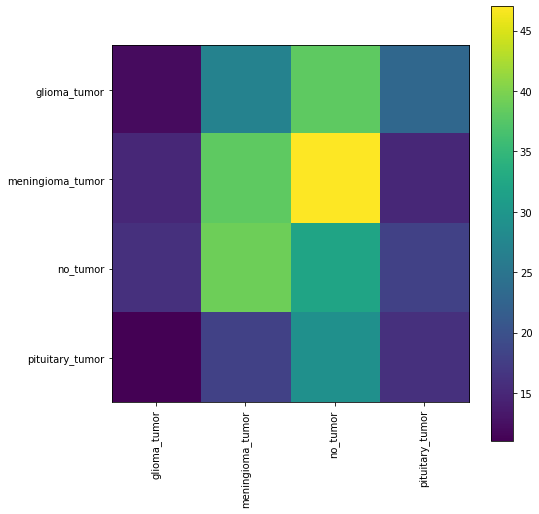

In [8]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# We need to recreate our validation generator with shuffle = false
test_set = train_datagen.flow_from_directory(test_dir , 
                                            target_size= (224 , 224) , 
                                            class_mode = "categorical" ,
                                            batch_size=16)

class_labels = test_set.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())


nb_validation_samples = 541
batch_size = 16

#Confution Matrix and Classification Report
Y_pred = model.predict(test_set ,  nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')
print(confusion_matrix(test_set.classes, y_pred))
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_set.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)